In [1]:
import os
from os import path
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd

if not 'BASE_DIR' in locals():
    BASE_DIR = os.path.abspath(os.curdir)

In [2]:
if os.path.abspath(os.curdir) == BASE_DIR:
    os.chdir('../')

dirname = os.path.abspath(os.curdir) + r'\data'
df = pd.read_csv(path.join(os.sep, dirname, 'Annual rainfall in Nottingham castle 1867  1939.csv'))
df = df['x']
df.head()

0    29.90
1    25.33
2    27.75
3    17.93
4    26.83
Name: x, dtype: float64

In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
def Fuller(name:str, df:pd.DataFrame):
    alpha = 0.05
    if hasattr(df, 'columns'):
        df = df[df.columns[0]]
    print(f'Тест Дики-Фуллера ряда {name} :')
    # определяем результат значения теста из библиотеки с учетом
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")
Fuller('Rainfall', df)

Тест Дики-Фуллера ряда Rainfall :
Test Statistic                 -3.383976
p-value                         0.011517
#Lags Used                      2.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


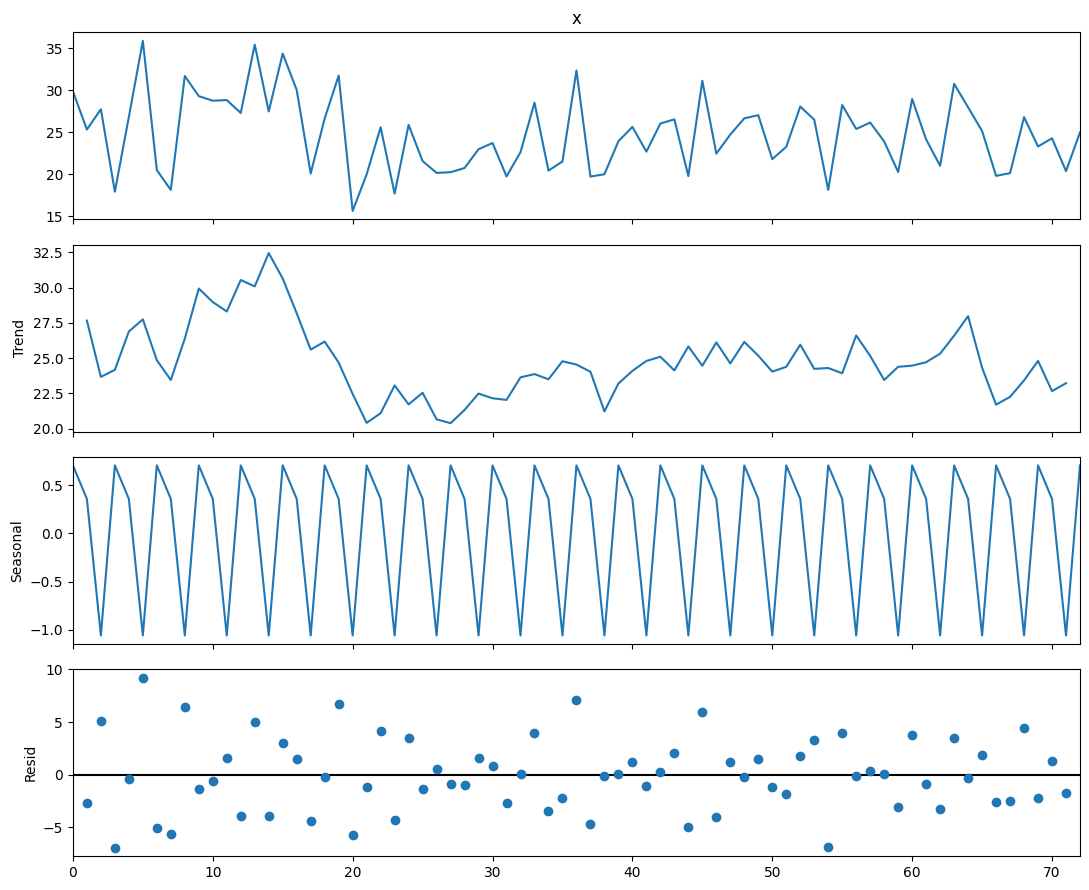

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
decompose = seasonal_decompose(df, 
                               period=3)
decompose.plot()
plt.show()

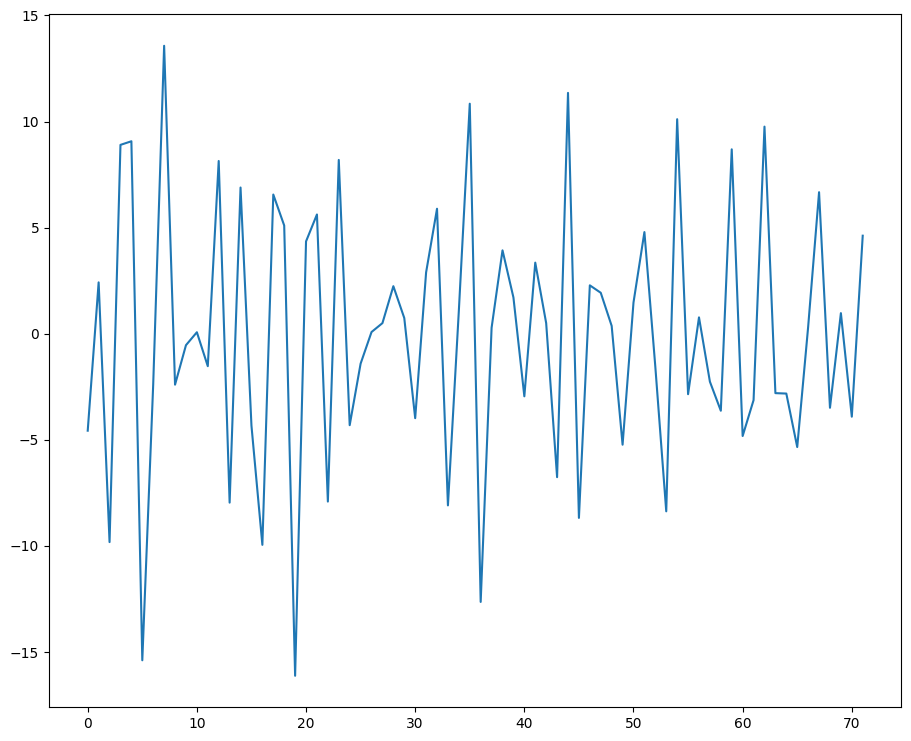

In [6]:
nottrend = []
s = 3
notseason = []

# выборка без тренда
for i in range(1, len(df)):
   nottrend.append(df[i] - df[i-1])

# выборка без сезонности
for i in range(s, len(df)):
   notseason.append(df[i] - df[i-s])
plt.plot(nottrend)

In [7]:
Fuller('Non Trend Rainfall', nottrend)

Тест Дики-Фуллера ряда Non Trend Rainfall :
Test Statistic                -9.725621e+00
p-value                        9.291536e-17
#Lags Used                     2.000000e+00
Number of Observations Used    6.900000e+01
Critical Value (1%)           -3.528890e+00
Critical Value (5%)           -2.904440e+00
Critical Value (10%)          -2.589656e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


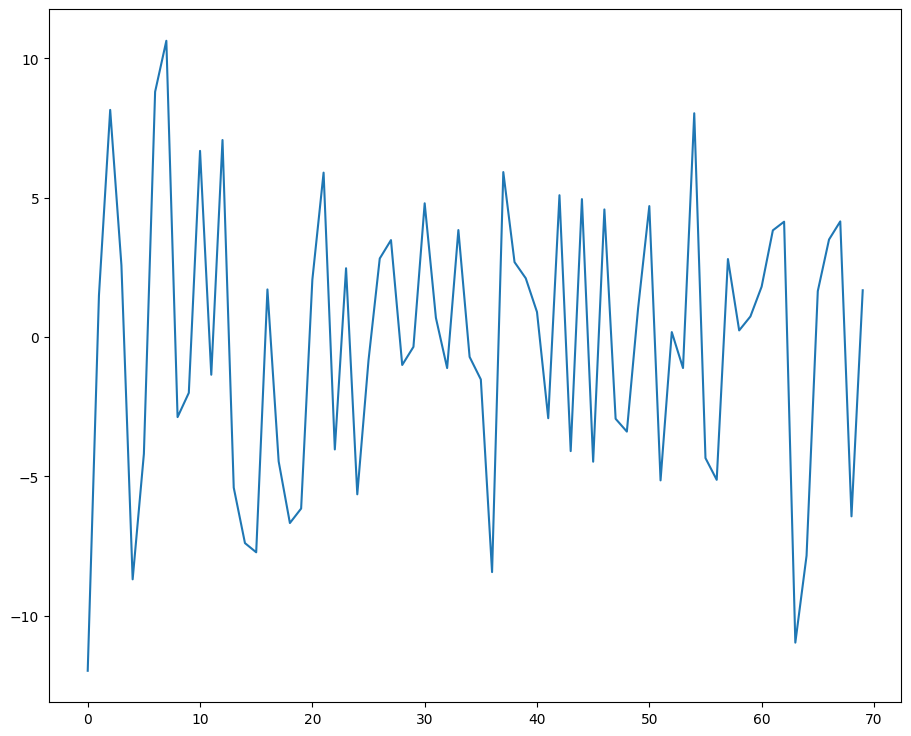

In [8]:
plt.plot(notseason)

In [9]:
Fuller('Non Season Rainfall', notseason)

Тест Дики-Фуллера ряда Non Season Rainfall :
Test Statistic                -7.039812e+00
p-value                        5.886483e-10
#Lags Used                     2.000000e+00
Number of Observations Used    6.700000e+01
Critical Value (1%)           -3.531955e+00
Critical Value (5%)           -2.905755e+00
Critical Value (10%)          -2.590357e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [10]:
from scipy.stats import boxcox 

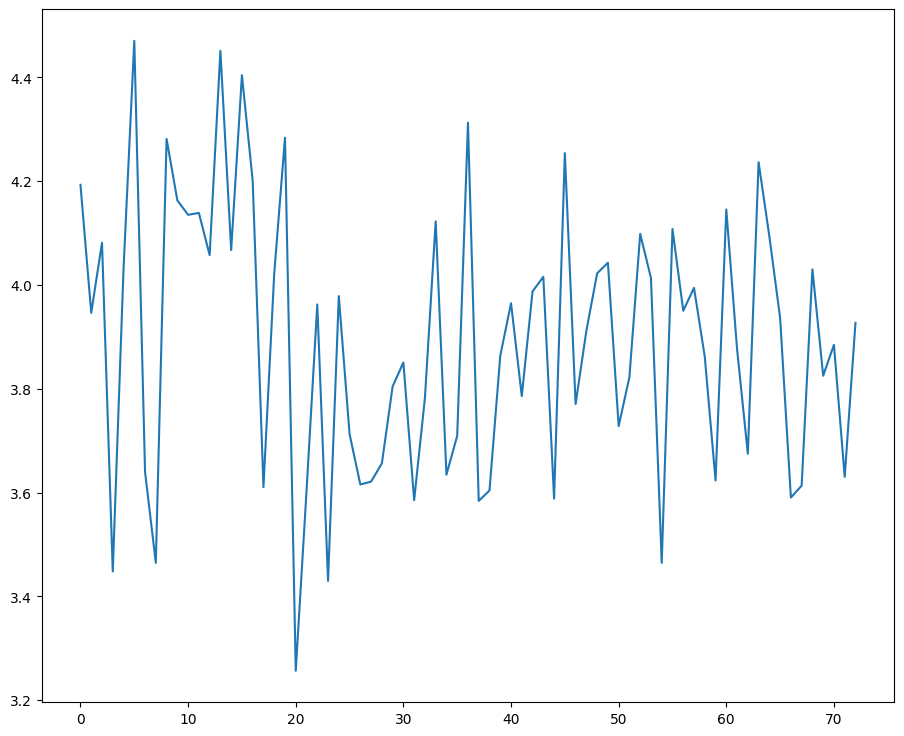

In [11]:
transformed_data, best_lambda = boxcox(df) 

plt.plot(transformed_data) 

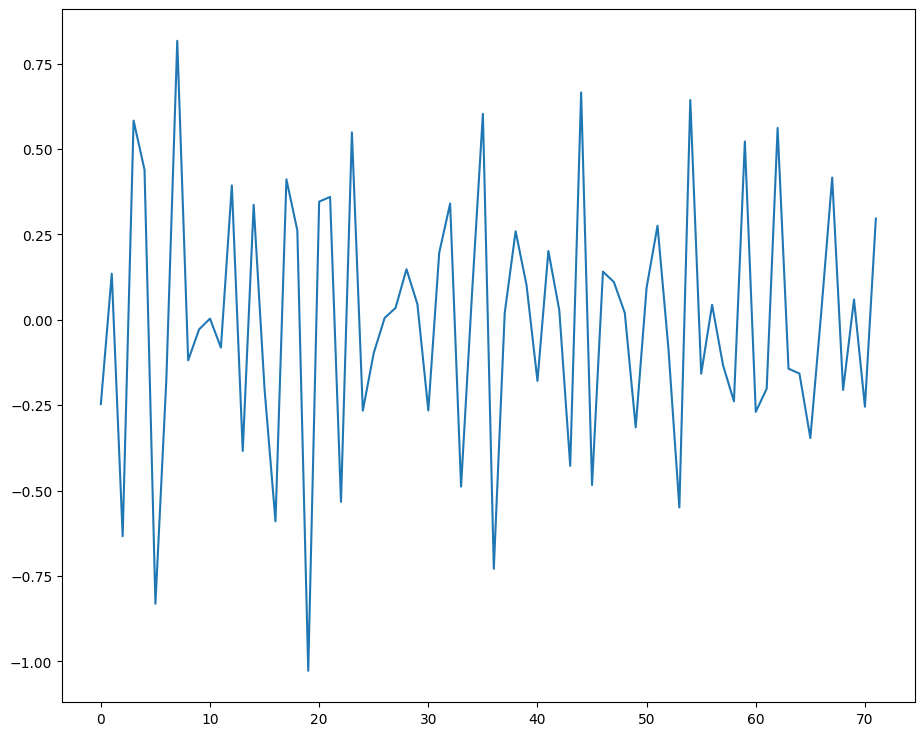

In [12]:


pnottrend = []

for i in range(1, len(transformed_data)):
   pnottrend.append(transformed_data[i] - transformed_data[i-1])


plt.plot(pnottrend) 



In [13]:
Fuller('BoxKox Rainfall', pnottrend)

Тест Дики-Фуллера ряда BoxKox Rainfall :
Test Statistic                -7.999497e+00
p-value                        2.354761e-12
#Lags Used                     3.000000e+00
Number of Observations Used    6.800000e+01
Critical Value (1%)           -3.530399e+00
Critical Value (5%)           -2.905087e+00
Critical Value (10%)          -2.590001e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [14]:
ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df.index<= train_cutoff]
validate_df = df[(df.index> train_cutoff) & (df.index<= validate_cutoff)]
forecast_df = df[df.index> validate_cutoff]

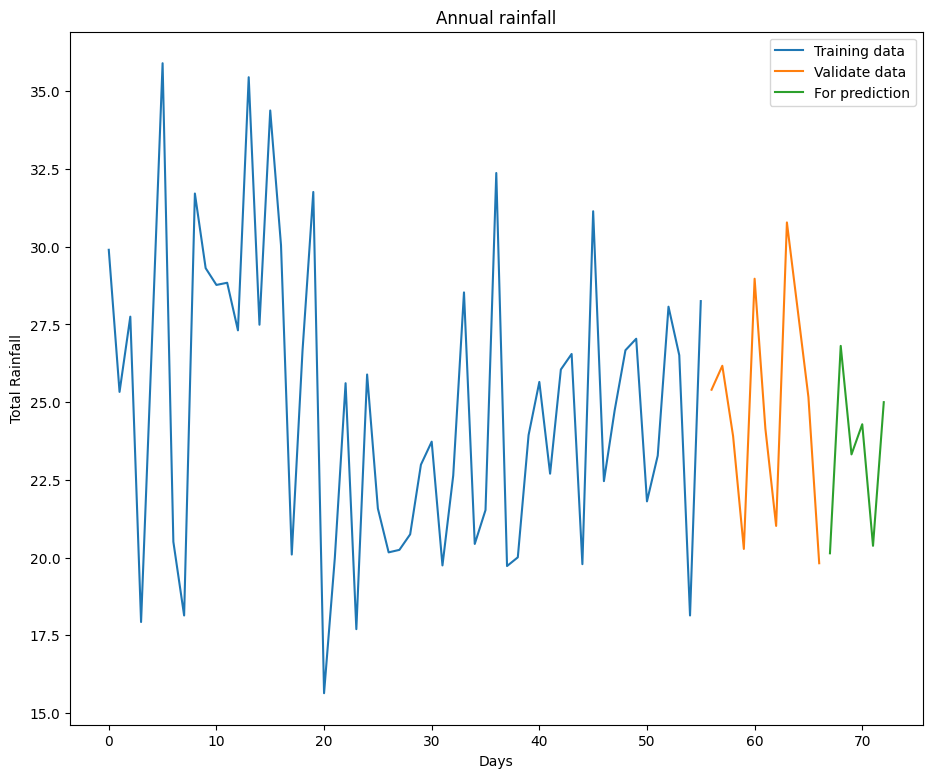

In [15]:
plt.plot(train_df.index, train_df, label='Training data')
plt.plot(validate_df.index, validate_df, label='Validate data')
plt.plot(forecast_df.index, forecast_df, label='For prediction')
plt.legend()
plt.title('Annual rainfall')
plt.ylabel('Total Rainfall')
plt.xlabel('Days')
plt.show()



In [16]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [17]:
mod = AutoReg(df, 3, old_names=False)
res = mod.fit()

print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   73
Model:                     AutoReg(3)   Log Likelihood                -198.025
Method:               Conditional MLE   S.D. of innovations              4.096
Date:                Thu, 19 Oct 2023   AIC                            406.050
Time:                        23:48:12   BIC                            417.293
Sample:                             3   HQIC                           410.516
                                   73                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.6318      4.838      3.438      0.001       7.150      26.113
x.L1           0.0477      0.109      0.437      0.662      -0.166       0.262
x.L2          -0.1195      0.109     -1.094      0.2

In [18]:
res = mod.fit(cov_type="HC0")

# смотрим, что изменилось
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   73
Model:                     AutoReg(3)   Log Likelihood                -198.025
Method:               Conditional MLE   S.D. of innovations              4.096
Date:                Thu, 19 Oct 2023   AIC                            406.050
Time:                        23:48:12   BIC                            417.293
Sample:                             3   HQIC                           410.516
                                   73                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.6318      4.748      3.503      0.000       7.327      25.937
x.L1           0.0477      0.097      0.493      0.622      -0.142       0.238
x.L2          -0.1195      0.134     -0.891      0.3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


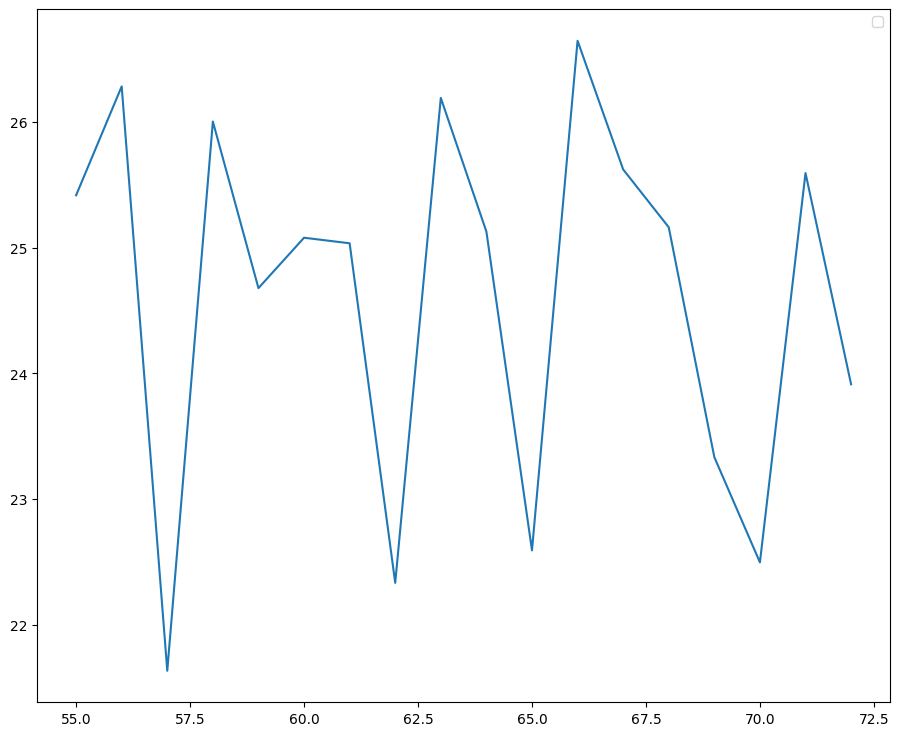

In [19]:
fig = res.plot_predict(train_cutoff)

In [20]:
len(df)

73

In [21]:
pred = res.predict(start=0, end=train_cutoff, dynamic=False)
v_pred = res.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff + 1, end=(len(df)-1), dynamic=False)

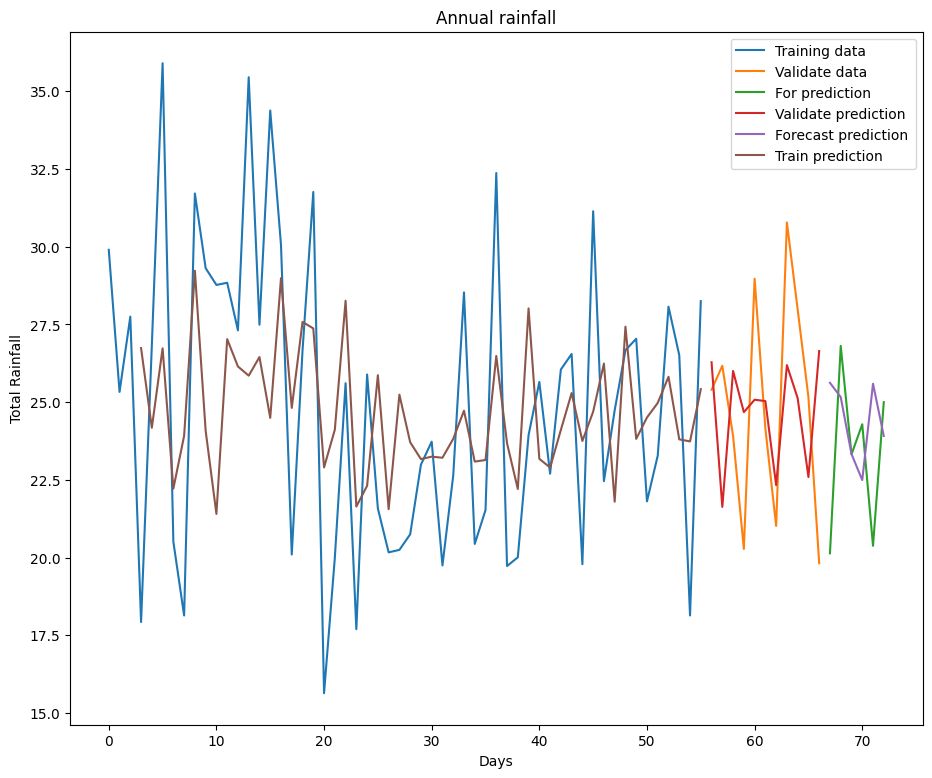

In [22]:


plt.plot(train_df.index, train_df, label='Training data')
plt.plot(validate_df.index, validate_df, label='Validate data')
plt.plot(forecast_df.index, forecast_df, label='For prediction')
plt.plot(validate_df.index, v_pred, label='Validate prediction ')
plt.plot(forecast_df.index, f_pred, label='Forecast prediction')
plt.plot(train_df.index, pred, label='Train prediction')

plt.legend()
plt.title('Annual rainfall')
plt.ylabel('Total Rainfall')
plt.xlabel('Days')
plt.show()



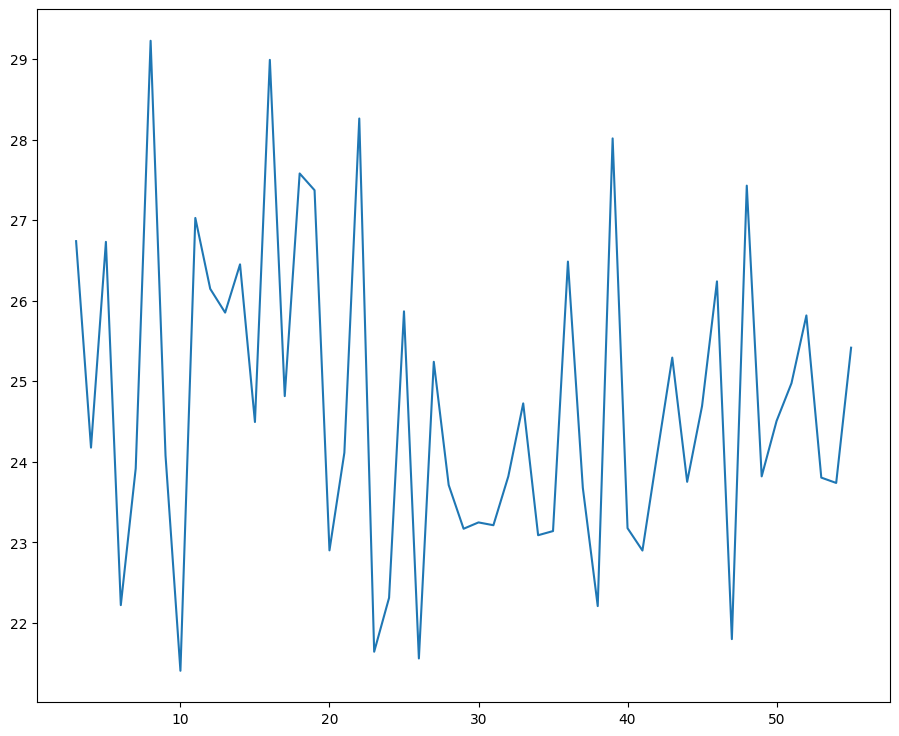

In [23]:
plt.plot(pred)

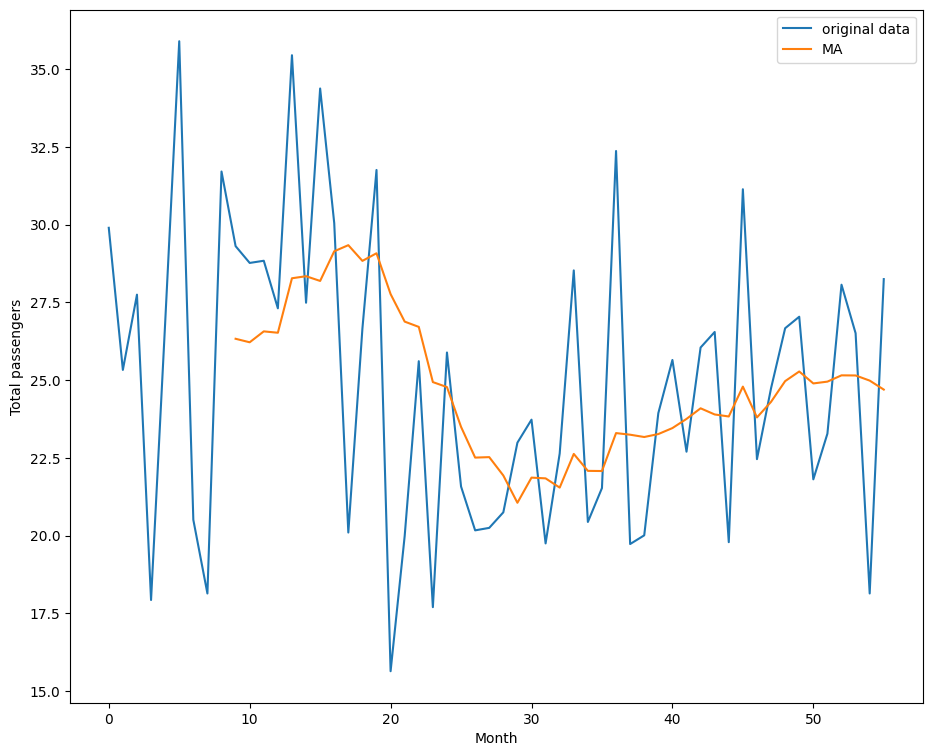

In [24]:

ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df.index <= train_cutoff]
validate_df = df[(df.index > train_cutoff) & (df.index <= validate_cutoff)]
forecast_df = df[df.index > validate_cutoff]

plt.plot(train_df.index, train_df, label="original data")
plt.plot(train_df.index, train_df.rolling(10).mean(), label="MA")
plt.legend()
plt.ylabel('Total passengers')
plt.xlabel('Month')
plt.show()

In [25]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [27]:
print("RMSE:", np.sqrt(mean_squared_error(forecast_df, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_df, f_pred))
print("MAE:", mean_absolute_error(forecast_df, f_pred))
print("R2: ", r2_score(forecast_df, f_pred))

RMSE: 3.2751801307909534
MAPE: 0.11790666110460339
MAE: 2.539811138134724
R2:  -0.8548145786115131
